In [1]:
import sys

import folium

from folium.features import DivIcon

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False
plt.rcParams.update({'font.size': 22})


# Setup the module path that contains the framework code
from pathlib import Path
module_path = str(Path.cwd())
if module_path not in sys.path:
    sys.path.append(module_path)

# Import the libraries
from modules.DataOperations import *
from modules.DataProcessing import *
from modules.MachineLearner import *

# Step 0. Introduction
This notebook contains demonstrations of methodologies presented in the following article,

https://arxiv.org/abs/2104.10289

Three library modules were developed as a part of these work: DataOperations, DataProcessing, and MachineLearner. These are located in the '/modules/' directory.

The original development environment consists of a data management service (backend) with postgresql capable of handling GIS queries. The server is yet to be made public. Hence, a subset of data relevant to the paper are loaded into separate files in the '/data/' directory. These are loaded and used in sections 3, 4, and 5. The framework is generalized and can be used with any spatio-temporal disease datasets with little or no modifications depending on the application. This notebook is an usage example of the library modules.

# Step 1. Helper/visualization functions
The following functions are used in this notebook to visualize results. These functionalities range from time series plots to interactive maps.

In [2]:
# Plotting functions
def plot_time_series(target_ic, ranked_pics, picSelect, inc_df, timeSelect):
    plt.figure(num=None, figsize=(16,6))
    for idx in picSelect:
        loc_id = ranked_pics[idx]
        plt.plot(inc_df['date'][timeSelect], inc_df[str(loc_id)][timeSelect], alpha=0.7, label=f'# {idx+1}: {loc_id}')
    
    plt.plot(inc_df['date'][timeSelect], inc_df[str(target_ic)][timeSelect], color='black', label = f'IC: {target_ic}')
    plt.ylim([0, 700])
    plt.legend(loc='upper left', ncol = 3)
    plt.xlabel('Time')
    plt.ylabel('Dengue cases per 100k')
    return plt

def plot_feat_performance(target_ic, test_error_dict, feature_counts, metric_index):
    test_errors = test_error_dict[target_ic]
    lstm_errors = []
    gru_errors = []
    linear_errors = []
    for nPIC in feature_counts:
        linear_errors.append(test_errors[nPIC]['Linear'][metric_index])
        lstm_errors.append(test_errors[nPIC]['LSTM'][metric_index])
        gru_errors.append(test_errors[nPIC]['GRU'][metric_index])

    ax = plt.figure(num=None, figsize=(16,6)).gca()
    plt.plot(feature_counts, linear_errors, 'o--', label = 'Linear')
    plt.plot(feature_counts, lstm_errors, 's--', label = 'LSTM')
    plt.plot(feature_counts, gru_errors, 'D--', label = 'GRU')
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    # plt.ylim([0.1, 1])
    plt.xlabel('Number of additional features, $N_{PIC}$')
    if metric_index == 1:
        plt.ylabel('Mean Absolute Error (MAE)')
    elif metric_index == 2:
        plt.ylabel('Mean Absolute Percentage Error (MAPE)')
    plt.legend(loc='upper center', ncol = 3)
    return plt, linear_errors, lstm_errors, gru_errors

def get_map(target_ic, ranked_pics, picSelect, pop_df, circ_scale, zoom_level):
    ic_data = pop_df.loc[int(target_ic)]
    ic_coords = [ic_data.lat, ic_data.lon]
    map_handle = folium.Map(location = ic_coords, zoom_start = zoom_level, tiles='cartodbpositron') # , tiles = 'CartoDB positron'
    
    # for target ic
    
    color = '#' + get_color_gradient(ic_data.case_frac_n, pop_df['case_frac_n'].min(), pop_df['case_frac_n'].max())
    circ_size = ic_data.case_tot_n
    folium.CircleMarker(
        location = ic_coords,
        radius = circ_size/circ_scale,
        popup = 'Target IC id: ' + str(target_ic) + ', cases: ' + str(ic_data.case_tot),
        color = 'red',
        weight = 2,
        fill = True,
        opacity = 0.8,
        fill_color = color, #'white',
        fill_opacity = 0.5
    ).add_to(map_handle)
    
    text = 'IC'
    folium.map.Marker(
        location = ic_coords,
        icon=DivIcon(
            icon_size = (150,36),
            icon_anchor=(10,15),
            html='<div style="font-size: 12pt">%s</div>' % text
        )
    ).add_to(map_handle)
    
    # for ranked pics
    for idx in picSelect:
        loc_id = ranked_pics[idx]
        pic_data = pop_df.loc[int(loc_id)]
        pic_coords = [pic_data.lat, pic_data.lon]
        circ_size = pic_data.case_tot_n
        color = '#' + get_color_gradient(pic_data.case_frac_n, pop_df['case_frac_n'].min(), pop_df['case_frac_n'].max())
        folium.CircleMarker(
            location = pic_coords,
            radius = circ_size/circ_scale,
            popup = 'PIC '+str(idx+1)+', id: ' + str(loc_id) + ', cases: ' + str(pic_data.case_tot) + ', dist: ' + str(int(distance(ic_coords, pic_coords).km)) + ' km',
            color = 'black',
            weight = 1,
            fill = True,
            opacity = 0.8,
            fill_color = color,
            fill_opacity = 0.5
        ).add_to(map_handle)
        
        text = 'PIC #' + str(idx+1)
        folium.map.Marker(
            location = pic_coords,
            icon=DivIcon(
                icon_size = (150,36),
                icon_anchor=(20,-circ_size/circ_scale), #-20
                html='<div style="font-size: 12pt">%s</div>' % text
            )
        ).add_to(map_handle)
    
    return map_handle

# Step 2. Initialize general parameters and objects
The directories are relative with respect to this notebook file. 

In [3]:
inc_data_file = 'data/inc_count.csv'
pop_data_file = 'data/pop.csv'
env_data_file = 'data/env_data_dict.npy'

optimal_features_dict = {}
env_data_dict = {}

# Step 3. Get incidence data

### Note 3.1. The project database is not publicly accessible, database queries are bypassed.

In [4]:
# region_id = 'ES'
# loc_data = get_brazil_location_data()
# locs_in_region_with_data = get_regional_locations(region_id, loc_data)
# inc_count_df = get_data_for_locs(locs_in_region_with_data)
# inc_count_df = inc_count_df[inc_count_df['date'] < '2020-08-23']

## Store the data read from the database
## inc_count_df.to_csv(inc_data_file, index=False)

### Note 3.2. The data are directly loaded from a stored csv from a prev session

In [5]:
inc_count_df = pd.read_csv(inc_data_file)
inc_count_df['date'] = pd.to_datetime(inc_count_df['date'])
inc_count_df.iloc[:, 1:] = inc_count_df.iloc[:, 1:].apply(pd.to_numeric)

outbreak_sizes = inc_count_df.sum().sort_values(ascending = False)

### Note 3.3. Variable descriptions
``inc_count_df``: contains weekly dengue case data (row) for a set of locations (columns). The columns headers indicate the location ids. The first column shows the dates.

``outbreak_sizes``: locations sorted based on prevalance (number of cases over the entire timeframe in inc_count_df)

# Step 4. Normalize incidence data with population data

### Note 4.1. Database queries are bypassed.

In [6]:
# pop_df = get_population_data(locs_in_region_with_data)

## Store the data read from the database
# pop_df.to_csv(pop_data_file, index=True)

### Note 4.2. Previously saved data loaded directly

In [7]:
pop_df = pd.read_csv(pop_data_file, index_col=0)

inc_ratio_df = normalize_case_counts(inc_count_df, pop_df)
outbreak_ratios = inc_ratio_df.sum().sort_values(ascending = False)
add_case_counts(pop_df, outbreak_sizes, outbreak_ratios)

### Note 4.3. Variable descriptions
``inc_ratio_df``: contains weekly dengue cases per 100,000 people (row) for a set of locations (columns). The columns headers indicate the location ids. The first column shows the dates.

``outbreak_ratios``: locations sorted based on prevalance (number of cases (per 100,000 people) over the entire timeframe in inc_ratio_df)

``pop_df``: For each location (row), this table contains the coordinates, population, prevalance (cases and cases per 100k), and normalized prevalence (scaled between 5:105)

# Step 5. Load environmental data for selected locations

### Note 5.1 Database queries bypassed

In [8]:
# ic_list = outbreak_ratios[0:20].index

# idx = 1
# for target_loc in ic_list:
    
#     print(f'Progress: IC number {idx} of {len(ic_list)}')
    
#     print(f'Target location id: {target_loc}')
    
#     lat, lon = get_loc_coord(target_loc)
#     print(f'Location coordinates (lat, lon): {lat}, {lon}')
    
#     # Get weather data
#     print('Obtaining weather station data ...')
#     daily_obs_df, dist = get_station_data(lat, lon, search_range=250, urlStation='http://10.135.76.81:3254/stations', urlObs='http://10.135.76.81:3254/observations', fromDate=inc_ratio_df['date'].min().date(), toDate=inc_ratio_df['date'].max().date(), tol=0.1)
    
#     # Convert to match the incidence data
#     Weather_obs_df = convert_weather_to_weekly(inc_ratio_df['date'], daily_obs_df)
    
#     # Get reanalysis data
#     print('Obtaining reanalysis data ...')
#     Reanalysis_df = get_rean_data(lat, lon, inc_ratio_df['date'])
#     obs_rean_df = pd.merge(Weather_obs_df, Reanalysis_df, how='outer', on='date')
#     env_data_dict[target_loc] = obs_rean_df
#     idx = idx + 1

# # Store the data read from the database
# np.save(env_data_file, env_data_dict)

### Note 5.2. Previously saved data loaded directly

In [9]:
env_data_dict = np.load(env_data_file, allow_pickle='TRUE').item()

### Note 5.3. Variable descriptions
``env_data_dict``: for each location, it contains multivarite time series data on weather and environmental conditions. The dictionary keys are the location ids and the values are dataframes (obs_rean_df).

``obs_rean_df``: for a given location, this dataframe contains weekly data on temperature (tavg, tmax, tmin), rainfall (prec), number of rainy days in a week, diurnal temperate range in a week (avg, max, min), reanalysis temp (avg), reanalysis relative humidity, reanalysis surface level pressure, and reanalysis precipitable water.

# Step 6. Train models

In [10]:
# List of target locations to run tests on
ic_list = ['3205309']

# Prediction window parameters (input/output data points (time-steps in weeks))
output_steps = 4
input_steps = 8

# train-eval-test split: 50 30 20 percents
split_frac = [.5, .3, .2]

iterations = 120
verbosity = 0

# Parameters: correlation window (please refer to section 3.1, 3.2 of https://arxiv.org/abs/2104.10289 for details)
max_shift = 15
data_splits = 20
comp_win_ext = 4
phase_ext = 1
min_corr = 0.1



# Parameters: PIC sorting configuration
# The boolean parameters enable/disable different metrics/weights. 
# prev_type selects either total number of cases (absolute) or a cases per 100k (relative) as prevalance weight
sort_options = {}
sort_options['corr_weight'] = True
sort_options['dist_weight'] = True
sort_options['prev_weight'] = True
sort_options['prev_type'] = 'relative'


# Different numbers of additional features (PICs) to run tests with
feature_counts = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 20, 25, 30]

optimal_feat_list = []

test_error_dict = {}
ranked_pic_dict = {}
forecast_window_dict = {}

linear_model_dict = {}
lstm_model_dict = {}
gru_model_dict = {}

idx = 1
for target_loc in ic_list:
    print(f'Progress: IC number {idx} of {len(ic_list)}')
    print(f'Target location id: {target_loc}')

    obs_rean_df = env_data_dict[target_loc]

    print('Computing predictabilities')
    pic_predictabilities = compute_predictability(ic_id = str(target_loc), inc_df = inc_ratio_df, lag_weeks = max_shift, no_of_windows = data_splits, side_len = comp_win_ext, min_corr = min_corr, extend_phase = phase_ext)
    
    ranked_pics = sort_predictors(pic_predictabilities, pop_df, int(target_loc), sort_options)
    ranked_pic_dict[target_loc] = ranked_pics


    print('Running ML fitting and evaluations')
    test_errors, forecast_windows, linear_models, lstm_models, gru_models = run_ml_predictions(target_loc, obs_rean_df, inc_ratio_df, ranked_pics, feature_counts, split_frac, input_steps, output_steps, iterations, verbosity)
    
    test_error_dict[target_loc] = test_errors
    forecast_window_dict[target_loc] = forecast_windows
    
    linear_model_dict[target_loc] = linear_models
    lstm_model_dict[target_loc] = lstm_models
    gru_model_dict[target_loc] = gru_models
    
    min_errors = find_best_performers(feature_counts, test_errors, 1)
    min_errors['loc_id'] = target_loc
    
    optimal_feat_dict = {}
    optimal_feat_dict.update(min_errors)
    optimal_feat_list.append(optimal_feat_dict)
    idx = idx + 1

optimal_features_df = pd.DataFrame(optimal_feat_list)
optimal_features_df.columns = ['linear', 'lstm', 'gru', 'loc_id']
optimal_features_df = optimal_features_df.set_index('loc_id')

Progress: IC number 1 of 1
Target location id: 3205309
Computing predictabilities
Running ML fitting and evaluations
Shape of dataset: (520, 13)
Fitting and predicting with 0 additional features
Shape of dataset: (520, 14)
Fitting and predicting with 1 additional features
Shape of dataset: (520, 15)
Fitting and predicting with 2 additional features
Shape of dataset: (520, 16)
Fitting and predicting with 3 additional features
Shape of dataset: (520, 17)
Fitting and predicting with 4 additional features
Shape of dataset: (520, 18)
Fitting and predicting with 5 additional features
Shape of dataset: (520, 19)
Fitting and predicting with 6 additional features
Shape of dataset: (520, 20)
Fitting and predicting with 7 additional features
Shape of dataset: (520, 21)
Fitting and predicting with 8 additional features
Shape of dataset: (520, 22)
Fitting and predicting with 9 additional features
Shape of dataset: (520, 23)
Fitting and predicting with 10 additional features
Shape of dataset: (520, 

### Note 6.1. Variable descriptions
``optimal_features_df``: for each target location / IC (row), the optimum number of PICs for each ML model tested with (column). The optimum value indicate the number of PICs from the feature_counts set for which test error was minimum (highest accuracy) 

# Step 7. Plot results

### 7.1. Plot results about PIC selection and predictive performance

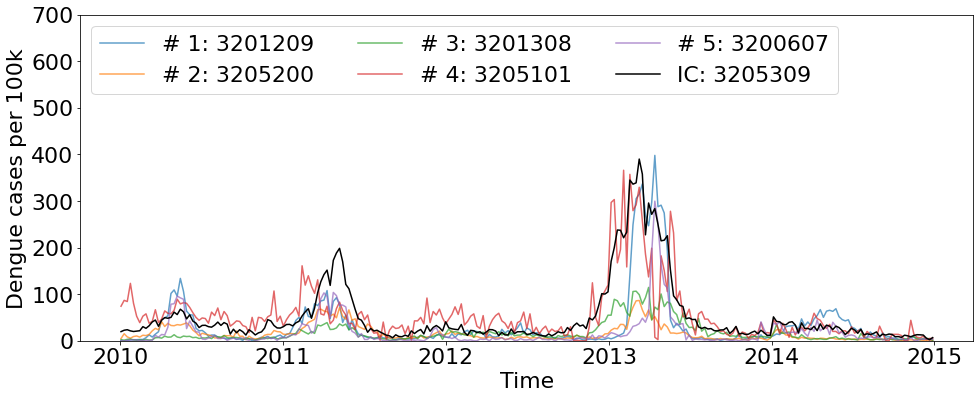

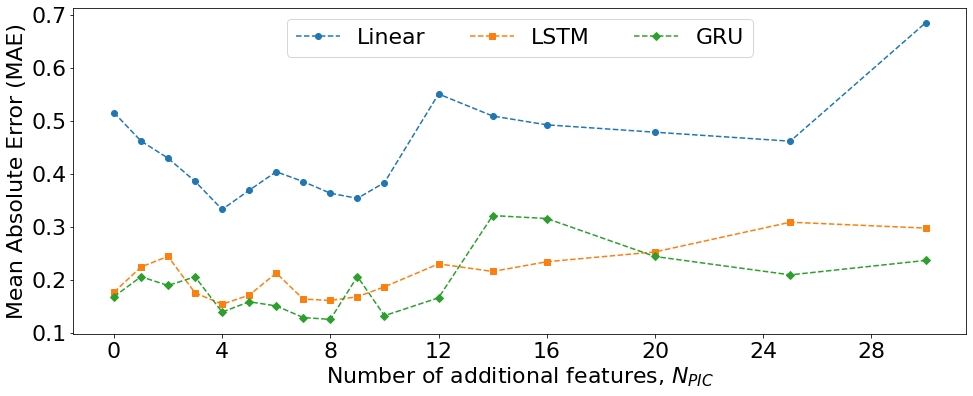

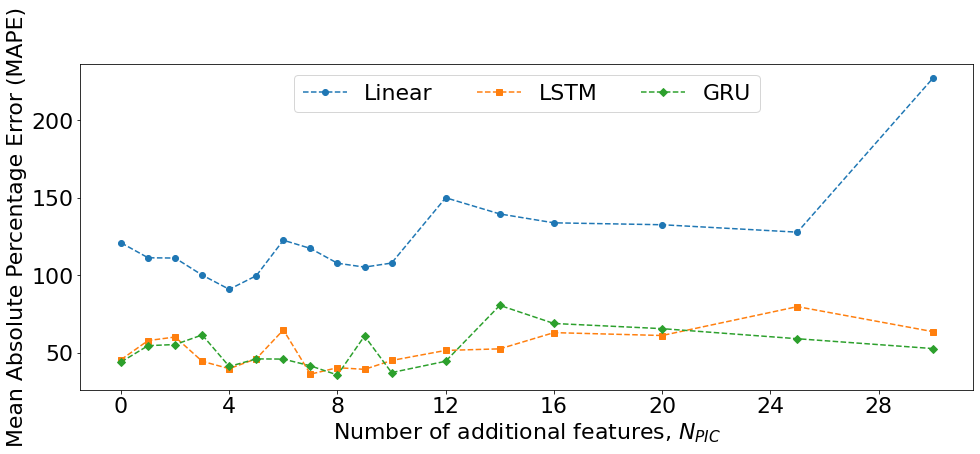

In [11]:
# Enter a target loc (IC) and the number of PICs to visualize in the map.
target_loc = ic_list[0]
nPIC = 5

circ_scale = 4
zoom_level = 9

picSelect = [x for x in range(0,nPIC)]
ranked_pics = ranked_pic_dict[target_loc]

# 1. Plot the time series graphs and compare with PICs with labels indicating ranks
timeSelect = np.arange(0,261)
plt = plot_time_series(target_loc, ranked_pics, picSelect, inc_ratio_df, timeSelect)
# plt.savefig('exports/data/'+region_id+'/Mf_20'+'/ic_'+str(target_loc)+'_npic_'+str(nPIC)+'_series.svg')

# 2. plot the feature vs error curve
plt, linear_errors, lstm_errors, gru_errors = plot_feat_performance(target_loc, test_error_dict, feature_counts, 1)
plt, linear_errors, lstm_errors, gru_errors = plot_feat_performance(target_loc, test_error_dict, feature_counts, 2)
# plt.savefig('exports/predictions/'+region_id+'/Mf_20'+'/ic'+str(target_loc)+'_mae_vs_nfeat.svg')

# 3. Mark the ranked pics in the map with indicating the ranks
ranked_pics = ranked_pic_dict[target_loc]
local_map = get_map(target_loc, ranked_pics, picSelect, pop_df, circ_scale, zoom_level)
f = folium.Figure(width=900, height=650)
f.add_child(local_map)

### 7.2. Plot time series predictions

Shape of dataset: (520, 21)
Shape of dataset: (520, 20)


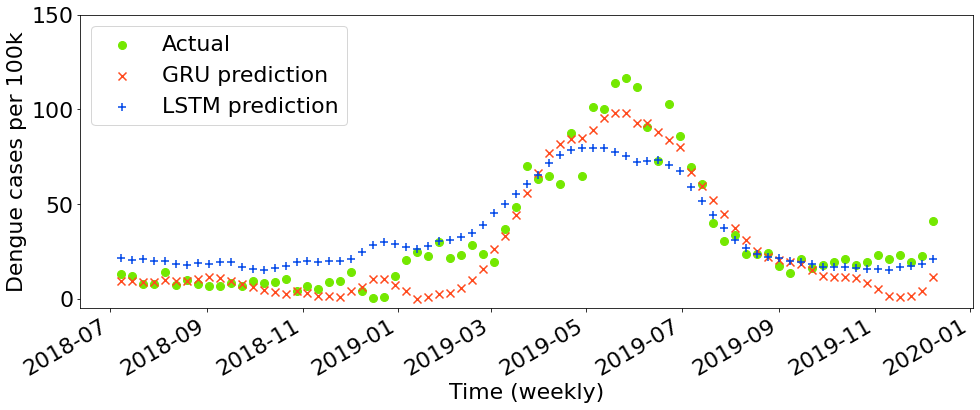

In [12]:
# Both GRU and LSTM
dataSlice = 20

# GRU
# Enter the number of PICs (nPIC) to get the appropriate predictor
nPIC = 8
ranked_pics = ranked_pic_dict[target_loc]
forecast_window = forecast_window_dict[target_loc][nPIC]
gru_model = gru_model_dict[target_loc][nPIC]
train_data, val_data, test_data, test_dates, train_mean, train_std, num_features = prepare_data(target_loc, obs_rean_df, inc_ratio_df, ranked_pics[0:nPIC], split_frac, False)
time_axis, label_array, prediction_array = forecast_window.combine_shifted_predictions(gru_model)
label_array = train_std['cases']*label_array + train_mean['cases']
gru_prediction_array = train_std['cases']*prediction_array + train_mean['cases']


# LSTM
# Enter the number of PICs (nPIC) to get the appropriate predictor
nPIC = 7
forecast_window = forecast_window_dict[target_loc][nPIC]
lstm_model = lstm_model_dict[target_loc][nPIC]
train_data, val_data, test_data, test_dates, train_mean, train_std, num_features = prepare_data(target_loc, obs_rean_df, inc_ratio_df, ranked_pics[0:nPIC], split_frac, False)
time_axis, label_array, prediction_array = forecast_window.combine_shifted_predictions(lstm_model)
label_array = train_std['cases']*label_array + train_mean['cases']
lstm_prediction_array = train_std['cases']*prediction_array + train_mean['cases']

fig = plt.figure(num=None, figsize=(16,6))
plt.scatter(time_axis[dataSlice:], label_array[dataSlice:], c='#74e800', s=64, label = 'Actual')
plt.scatter(time_axis[dataSlice:], gru_prediction_array[dataSlice:], marker='x', c='#ff4b1f', s=64, label = 'GRU prediction')
plt.scatter(time_axis[dataSlice:], lstm_prediction_array[dataSlice:], marker='+', c='#0046e8', s=64, label = 'LSTM prediction')
plt.legend(loc='upper left')
plt.xlabel('Time (weekly)')
plt.ylabel('Dengue cases per 100k')
plt.ylim([-5, 150])
fig.autofmt_xdate()
# plt.savefig('exports/predictions/'+region_id+'/series_mf_20_pred_ic_'+str(target_loc)+'_LSTM_GRU_.svg')